In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt

paths = {}

import os
for dirname, _, filenames in os.walk(r"C:\Users\HP\Downloads\archive (3)"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        paths[filename] = os.path.join(dirname, filename)

C:\Users\HP\Downloads\archive (3)\movies.csv
C:\Users\HP\Downloads\archive (3)\ratings.csv


In [13]:
from sklearn.preprocessing import MultiLabelBinarizer # one-hot encoding 
from sklearn.neighbors import NearestNeighbors # KNN

In [14]:
ratings = pd.read_csv(paths["ratings.csv"])
movies = pd.read_csv(paths["movies.csv"])

print("Datasets loaded")

Datasets loaded


In [15]:
print(movies.shape)
movies.head()

(62423, 3)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
print(ratings.shape)
ratings.head()

(25000095, 4)


,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [17]:
unique_users = len(ratings["userId"].unique())
movies_count = len(movies["movieId"].unique())

print(unique_users, movies_count)

162541 62423


<Axes: xlabel='rating'>

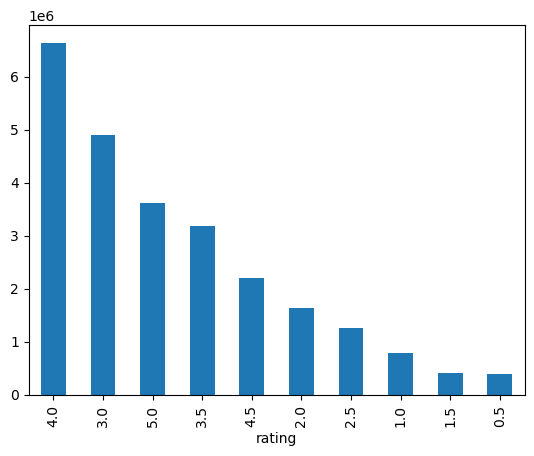

In [19]:
ratings['rating'].value_counts().plot(kind='bar')


In [20]:
# combine data
merged_data = pd.merge(ratings, movies, on='movieId')

print(merged_data.shape)
merged_data.head()

(25000095, 6)


,userId,movieId,rating,timestamp,title,genres
0,1,296,5.0,1147880044,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,1,306,3.5,1147868817,Three Colors: Red (Trois couleurs: Rouge) (1994),Drama
2,1,307,5.0,1147868828,Three Colors: Blue (Trois couleurs: Bleu) (1993),Drama
3,1,665,5.0,1147878820,Underground (1995),Comedy|Drama|War
4,1,899,3.5,1147868510,Singin' in the Rain (1952),Comedy|Musical|Romance


In [21]:
data = movies

# one-hot encoding
mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(data['genres'].str.split('|'))
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)

data = pd.concat([data, genre_df], axis=1)
data.head()

,movieId,title,genres,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
features = data.drop(columns=[
#     'userId', 'rating', 'timestamp', 
    'genres', 'title', 'movieId'])

features.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
knn_model_genres = NearestNeighbors(n_neighbors=5, algorithm='auto')
knn_model_genres.fit(features)

NearestNeighbors()

In [64]:
import re
import pandas as pd

def preprocess_title(title):
    # Remove non-alphabetic characters and convert to lowercase
    return re.sub(r'[^a-zA-Z\s]', '', title).lower()

def recommend_similar_movies_model1(movie_title, *, n=5, model=knn_model_genres, data=movies, features=features):
    # Preprocess the input movie title
    processed_title = preprocess_title(movie_title)
    
    # Apply preprocessing to all titles in the data and find the index
    data['processed_title'] = data['title'].apply(preprocess_title)
    try:
        movie_idx = data[data['processed_title'] == processed_title].index[0]
    except IndexError:
        raise ValueError(f"Movie '{movie_title}' not found in the dataset.")
    
    # Select the feature vector, reshape, and convert to DataFrame with feature names
    feature_vector = features.iloc[movie_idx, :].values.reshape(1, -1)
    feature_df = pd.DataFrame(feature_vector, columns=features.columns)
    
    # Find the k-nearest neighbors
    distances, indices = model.kneighbors(feature_df, n_neighbors=n)
    recommended_movies = data.iloc[indices.flatten()]
    
    # Drop the helper column after use
    data.drop(columns=['processed_title'], inplace=True)
    
    return recommended_movies

# Example usage:
recommend_similar_movies_model1("Heat (1995)")

,movieId,title,genres,processed_title
1864,1953,"French Connection, The (1971)",Action|Crime|Thriller,french connection the
37612,153032,Dus (2005),Action|Crime|Thriller,dus
52768,186001,True Crimes (2016),Action|Crime|Thriller,true crimes
54674,190123,Diamond 13 (2009),Action|Crime|Thriller,diamond
54199,189045,Revolver (1973),Action|Crime|Thriller,revolver


In [ ]:
# training on 5% of all data for performance reasons
filtered_data = merged_data.head(merged_data.shape[0] // 20)

user_item_matrix = filtered_data.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)
print(user_item_matrix.shape)

In [ ]:
mean_user_rating = np.mean(np.array(user_item_matrix), axis=1).reshape(-1, 1)

normalized_matrix = user_item_matrix - mean_user_rating

In [ ]:
knn_model_matrix = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='auto')
knn_model_matrix.fit(normalized_matrix)

In [ ]:
import re

def preprocess_title(title):
    # Remove non-alphabetic characters and convert to lowercase
    return re.sub(r'[^a-zA-Z\s]', '', title).lower()

def recommend_similar_movies_model2(movie_title, n=5, model=knn_model_matrix, data=filtered_data.copy(), features=normalized_matrix):
    # Preprocess the input movie title
    processed_title = preprocess_title(movie_title)
    
    # Apply preprocessing to all titles in the copied data
    data['processed_title'] = data['title'].apply(preprocess_title)
    
    # Find the index of the matching movie in the data
    try:
        movie_idx = data[data['processed_title'] == processed_title].index[0]
    except IndexError:
        raise ValueError(f"Movie '{movie_title}' not found in the dataset.")

    # Get the k-nearest neighbors for the found movie
    distances, indices = model.kneighbors(features.iloc[movie_idx].values.reshape(1, -1), n_neighbors=n)
    recommended_movies = data.iloc[indices.flatten()]
    
    # Drop the helper column after use
    data.drop(columns=['processed_title'], inplace=True)
    
    return recommended_movies

# Example usage:
recommend_similar_movies_model2("12 Angry Men ")


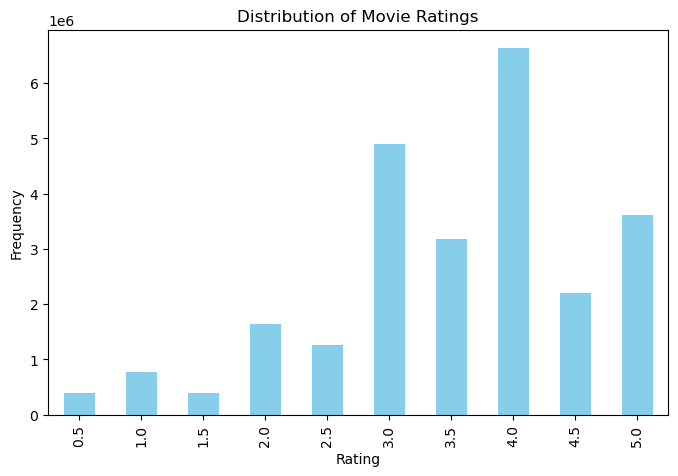

In [65]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
ratings['rating'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

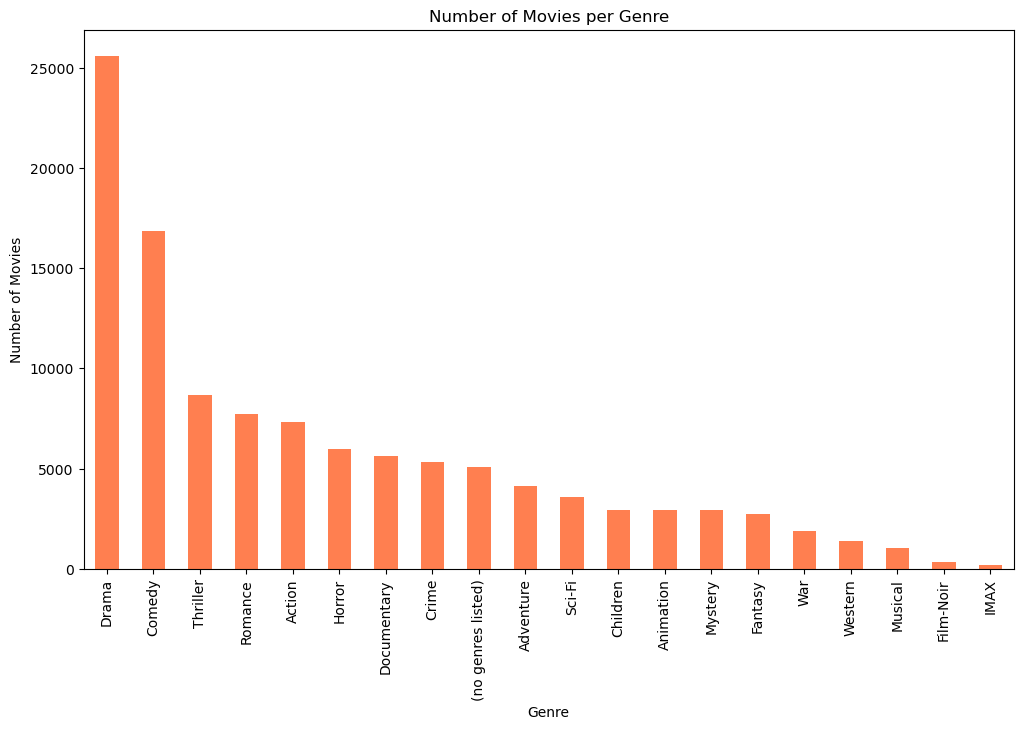

In [66]:
# Number of movies per genre
genre_counts = genre_df.sum().sort_values(ascending=False)
plt.figure(figsize=(12, 7))
genre_counts.plot(kind='bar', color='coral')
plt.title("Number of Movies per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.show()

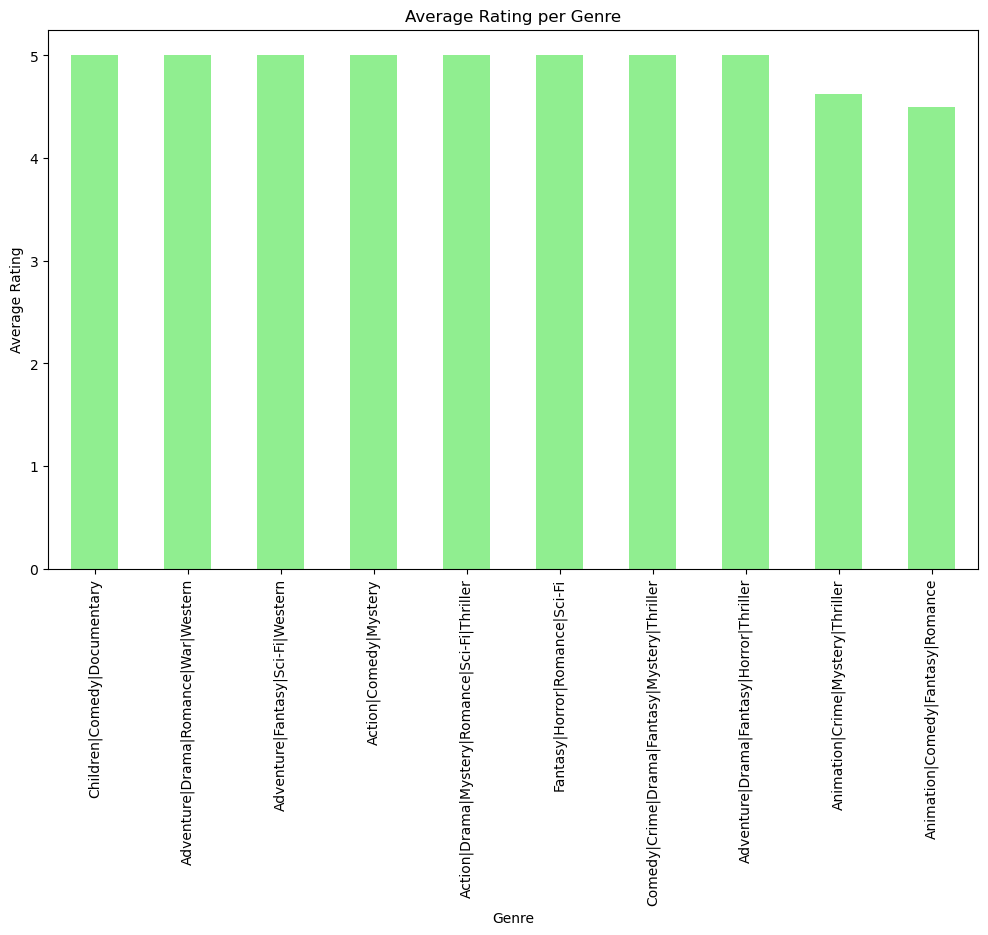

In [67]:
# Average rating per genre
avg_ratings_genre = merged_data.groupby('genres')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
avg_ratings_genre.plot(kind='bar', color='lightgreen')
plt.title("Average Rating per Genre")
plt.xlabel("Genre")
plt.ylabel("Average Rating")
plt.show()

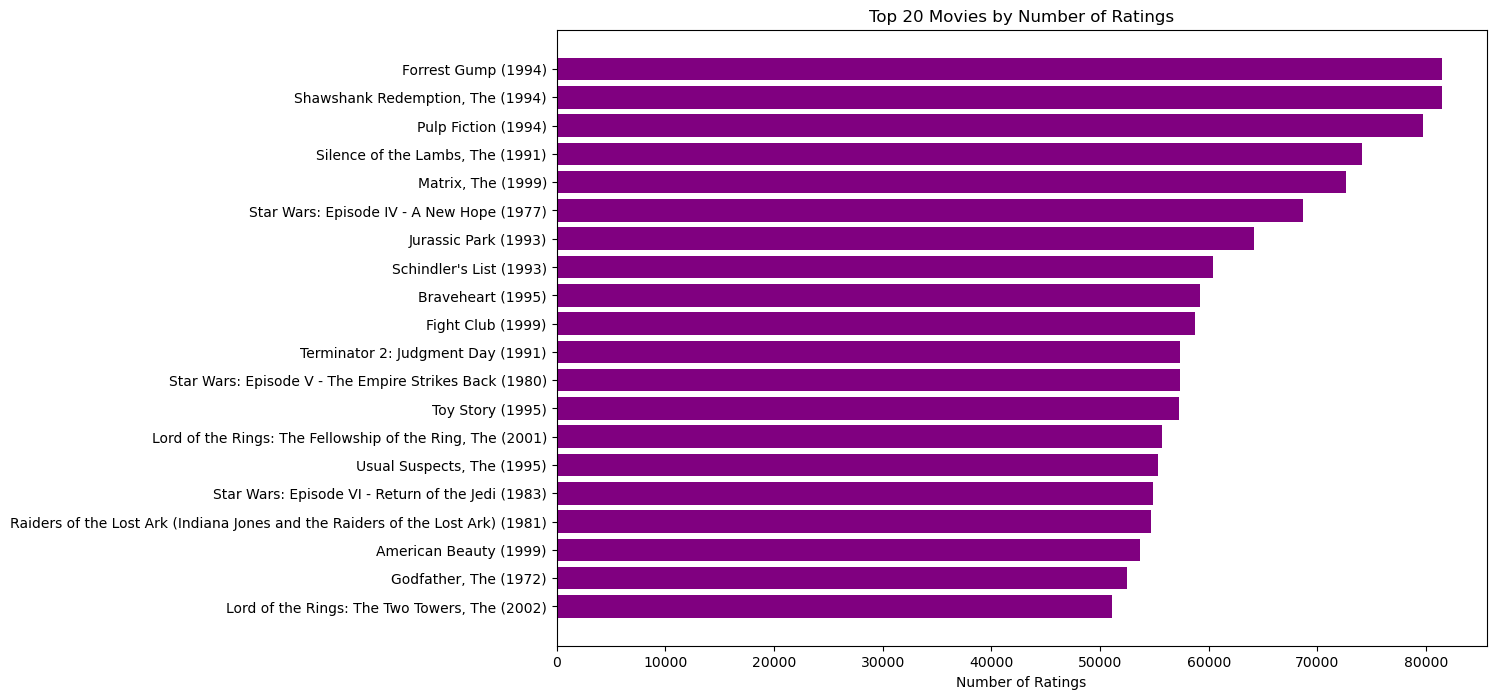

In [68]:
# Number of ratings per movie
ratings_per_movie = ratings.groupby('movieId').size().sort_values(ascending=False).head(20)
top_movies = movies.set_index('movieId').loc[ratings_per_movie.index]['title']
plt.figure(figsize=(12, 8))
plt.barh(top_movies, ratings_per_movie, color='purple')
plt.xlabel("Number of Ratings")
plt.title("Top 20 Movies by Number of Ratings")
plt.gca().invert_yaxis()
plt.show()

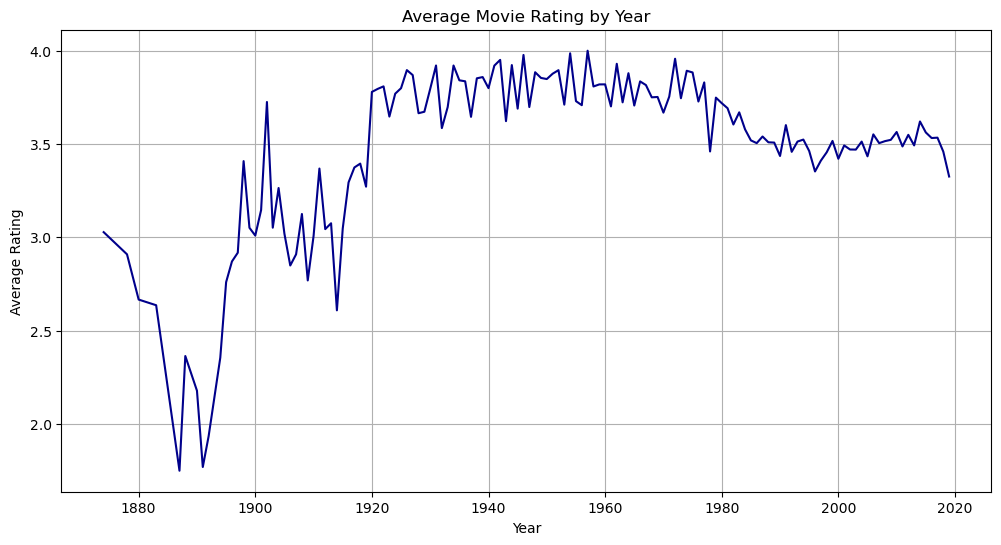

In [67]:
# Extract year from title and add as a new column if not present
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)
avg_rating_by_year = merged_data.merge(movies[['movieId', 'year']], on='movieId').groupby('year')['rating'].mean()

plt.figure(figsize=(12, 6))
avg_rating_by_year.plot(color='darkblue')
plt.title("Average Movie Rating by Year")
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.show()